# **Feature Selection, Feature Extraction, Cross-Validation, Pipeline and Grid Search (Predicting Breast Cancer Using KNN)**

In this project some of the basic components of machine learning methods are presented and examined. These components include feature selection based on correlation, feature extraction using principal component analysis (PCA) and hyperparameter tuning through cross-validation using packages available in `scikit-learn`. KNN is used in a k-fold cross-validation process to predict new cases of breast cancer. The breast cancer Wisconsin dataset is used for this purpose which is a classic and binary dataset available as one of the `scikit-learn` datasets. This project has five parts:

 - **Part 1: Exploratory Data Analysis**: A dataframe is created. Data is split into training and test sets and standardized in a way that there is no leakage from the test set. Then, only the training set is used for visualization.
 
 - **Part 2: Using All Features**: KNN with all the dataset features is used for predicting breast cancer. Each of part 2, 3 and 4 of this project has three sections. In the first section, for different number of neighbors, KNN is applied to the trainiing set without cross-validation, and the test score is reported for each number of neighbors. In the next section hyperparameter tuning is done to find the best number of neighbors in KNN using cross-validation for the training data. A loop over number of neighbors and `cross_val_score` is used in this section. The last step of part 2, 3 and 4 includes using `GridSearchCV` for cross-validation and hyperparameter tuning. 

 - **Part 3: Feature Selection**: Based on the correlation between features and the target, and the correlation between features themselves, a function is designed to drop some of the features. This function accepts training dataset and order the features based on correlation with the target, then from each two highly correlated features the one which has a weaker correlation with the target is dropped. Then similar to part 2, KNN is used for predicting breast cancer without and with cross-validation based on the new set of features.

 - **Part 4: Feature Extraction**: Principal component analysis (PCA) is applied to the training data to extract the most important components (eigenvectors) using singular value decomposition (SVD) of training data or eigendecomposition of the covariance matrix. Then similar to part 2 and 3, KNN is used for predicting breast cancer without and with cross-validation based on the new set of extracted features (which are not the same as the original features).

 - **Part 5: Standardization, Feature Extraction, Cross-Validation and Parameter Tuning, All Together Using Pipeline and GridSearchCV (NO DATA LEAKAGE)**: The proper manner of performing feature extraction is getting it done during cross-validation. In fact there should be no leakage from validation set (the test set inside the training data used in cross-validation) and from the test data. This is done by using a `Pipeline` for cross-validation. Here, a `Pipeline` includes standardization, PCA and KNN. Then combinations of different number of PCA components and KNN neighbors are used for hyperparameter tuning by cross-validation using `GridSearchCV`. This way the optimum parameters are found while making sure there is no data leakage. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -U scikit-learn  # Install the latest version of scikit-learn

Requirement already up-to-date: scikit-learn in /opt/anaconda3/lib/python3.8/site-packages (0.23.2)


Before doing exloratory data analysis let's import all the necessary libraries and packages which will be used in this project. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm  # Built-in colormaps and colormap handling utilities
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.preprocessing import StandardScaler  # For standaridizing the data
from sklearn.neighbors import KNeighborsClassifier  # Import k-nearest neighbors classifier model
from sklearn.metrics import accuracy_score  # Import accuracy_score for checking accuracy
from sklearn.model_selection import cross_val_score  # For k-fold cross-validation
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline  # For making a pipeline 
from sklearn.decomposition import PCA  # For feature extraction using PCA
from sklearn.model_selection import GridSearchCV  # For performing cross-validation using GridSearchCV
import itertools

# Part 1: Exploratory Data Analysis

First, the breast cancer Wisconsin dataset is loaded. As is seen the output is a Bunch object which is a special type of dictionary supporing attribute-style access. In version 0.23 of `scikit-learn` it has become possible to export the data part and the target part of this dataset as pandas objects which makes creating the final dataframe easier. We will show three methods for creating the dataframe but before that we extract some information from our Bunch object. Later the data is split into training set and testing set, and standardized in a way making sure there is no leakage from the test set. In the last step of exploratory data analysis, the training data is used to visualize some of the features and it is demonstrated that there is strong correlation between some features which makes it necessary to perform feature selection or feature extraction later on. 

In [2]:
dataset = load_breast_cancer()

In [5]:
type(dataset)

sklearn.utils.Bunch

In [6]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

The full description of the dataset is given here. It is seen that the number of instances (participants) is `569` where `357` cases are `benign` and `212` cases are `malignant`. There are `30` features (attributes) in the dataset.

In [7]:
## The full description of the dataset ##

print(dataset['DESCR'])  # print(dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Information regarding the features, including their numbers and names can be obtained using the following lines.

In [8]:
# print(type(dataset['feature_names']))
print(dataset['feature_names'].shape)  # print(dataset.feature_names.shape)
print('Features: {}'.format(dataset['feature_names']))  # print('Feature names: {}'.format(dataset.feature_names))

(30,)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Target names and the corresponing numbers are found as follows. 

In [9]:
# print(type(dataset.target_names))
print('Target names: {}'.format(dataset['target_names']))  # print('Target names: {}'.format(dataset.target_names))

Target names: ['malignant' 'benign']


In [10]:
# print(type(dataset['target']))  # print(type(dataset.target))
print(dataset['target'].shape)  # print(dataset.target.shape)
print('Targets: {}'.format(set(dataset['target'])))  # print('Targets: {}'.format(set(dataset.target)))

(569,)
Targets: {0, 1}


As sum of the column target is `357`, `1` represnets benign cases for this dataset. 

In [11]:
print('Sum of column target = {}'.format(sum(dataset['target'])))  # print('Sum of column target = {}'.format(dataset.target)))
print('Therefore 1 represents benign.')

Sum of column target = 357
Therefore 1 represents benign.


As expected the data part of this dataset has 30 columns (attributes, features) and 569 rows (instances, samples).

In [12]:
print(type(dataset['data']))  # print(type(dataset.data))
print(dataset['data'].shape)  # print(dataset.data.shape)
print(dataset['data'].size)  # print(dataset.data.size)

<class 'numpy.ndarray'>
(569, 30)
17070


## Part 1.1: Creating the DataFrame

Here three methods are presented for creating the dataframe. In the first method a more recent feature of `scikit-learn` is used which lets us import the data and target directly as pandas objects. In the second and third method the dataframe is created using the information available in the previously imported Bunch object. 

**Method 1**

**Question 1**: Create the breast cancer dataframe using the most recent features of scikit-learn which lets you import and create the dataframe in one line. For more information visit https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html. 

In [3]:
df = pd.concat(load_breast_cancer(return_X_y=True, as_frame=True), axis=1)  # Creating the dataframe using the more recent features of scikit-learn

In [ ]:
#Nils
df = pd.concat([load_breast_cancer(return_X_y=True, as_frame=True)[0], load_breast_cancer(return_X_y=True, as_frame=True)[1]], axis= 1)

**Method 2**

**Question 2**: Create the breast cancer dataframe using a one-line command from the Bunch object `dataset` created before. Use a one-line command.

In [60]:
df = pd.DataFrame(np.c_[dataset['data'], dataset['target']], columns=np.append(dataset['feature_names'], ['target']))  # Creating the dataframe from the Bunch object in one line

In [ ]:
#Nils
df1 = pd.DataFrame(data = np.c_[dataset['data'], dataset['target']], columns = np.append(dataset['feature_names'], ["target"]) )

**Method 3**

**Question 3**: Use a third method for creating the dataframe from the Bunch object `dataset`, not necessarily in one line.

In [6]:
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])  # This creates DataFrame without a column for target
df['target'] = dataset.target  # Adding a column for target

In [ ]:
#Nils
def create_dataframe():
    
    data = np.c_[load_breast_cancer().data, load_breast_cancer().target]
    columns = np.append(load_breast_cancer().feature_names, ["target"])
    return pd.DataFrame(data, columns=columns)

df2 = create_dataframe()

By taking a look at the head of the dataframe and its statistical information it is clear that some features have totally different scales and the data is not standardized or normalized. 

**Question 4**: Display the first five rows of the dataframe.

In [16]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**Question 5**: Display some basic statistical information of the dataframe including mean and standard deviation of each column. 

In [17]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Here we check data types for the features and the target. All the data types are numeric which makes working with this dataframe easier.

**Question 6**: Use a command to display the data type for all the features and the target.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Once more as a practice some information of the dataset is generated using the dataframe itself not the Bunch object we previously explored. 

**Question 7**: Display features of the dataframe.

In [19]:
print('Fearues = {}'.format(df.columns.values))

Fearues = ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'
 'target']


**Question 8**: Display the target values and their frequencies.

In [20]:
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

**Question 9**: Extract and display the number of features, samples, malignant cases, and benign cases.

In [21]:
N_total = len(df)  # Number of samples
N_malignant = len(df[df['target']==0])  # Number of malignant cases
N_benign = len(df[df['target']==1])  # Number of benign cases

In [22]:
print('Number of features: {}'.format(df.shape[1]-1))
print('Target classes: {}'.format(set(df['target']))) 
print('Number of participants: {}'.format(N_total))
print('Number of participants tested malignant: {}'.format(N_malignant))
print('Number of participants tested benign: {}'.format(N_benign))

Number of features: 30
Target classes: {0, 1}
Number of participants: 569
Number of participants tested malignant: 212
Number of participants tested benign: 357


## Part 1.2: Splitting and standardizing the data

A function is defined to split the dataset into training and testing sets, standardize the dataset using training set making sure there is no leakage from the test set. The outputs `X_train`, `X_test` are in the form of pandas dataframe and `y_train` and `y_test` are in the form of pandas series.

**Question 10**: Define a function which splits the dataset into training and testing sets, and standardizes the data. Check out the functions provided by `scikit-learn` to complete this task: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html, https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.

In [13]:
## Function to split and standardize the dataset ##

def split_standard(df, target, test_size, random_state):
  '''
  target: name of the column target
  '''

  ## Split the data ##
  X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=test_size, random_state=random_state)

  ## Applying StandardScaler to the DataFrame ##
  SS = StandardScaler()
  X_train = SS.fit_transform(X_train)  # Can be applied to both dataframe and numpy array
  X_test = SS.transform(X_test)  # Using the previously fitted transformation for the test data

  ## Converting X_train and X_test to DataFrame which might be useful later on ##
  X_train = pd.DataFrame(X_train, columns=dataset.feature_names).set_index(y_train.index)  # The index of X_train is set equal to the index of y_train
  X_test = pd.DataFrame(X_test, columns=dataset.feature_names).set_index(y_test.index)  # The index of X_test is set equal to the index of y_test

  return X_train, X_test, y_train, y_test

In [7]:
#Nils
def split_standard(df, target, t, s):
    
## Split the data ##

    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=t, random_state=s)
    
    
## Applying StandardScaler to the DataFrame ##
    scaler = StandardScaler()
    Train = scaler.fit_transform(X_train)
    
    
## Converting X_train and X_test to DataFrame which might be useful later on ##
    X_train = pd.DataFrame(Train, columns=dataset.feature_names).set_index(y_train.index)  # The index of X_train is set equal to the index of y_train
    X_test = pd.DataFrame(X_test, columns=dataset.feature_names).set_index(y_test.index)  # The index of X_test is set equal to the index of y_test



    return X_train, X_test, y_train, y_test

In [14]:
## Split and standardize data ##

X_train, X_test, y_train, y_test = split_standard(df, 'target', test_size=0.2, random_state=0)  # 80% training and 20% test

## Part 1.3: Visualizing the standardized training data

Here some features and the correlations between them are visualized. Training data (after standardization) is used for visualization. It is seen that there is a strong correlation between some of the feaures. It is also clear that the distributions of highly correlated features are similar. 

In [15]:
## Creating a dataframe including X_train and y_train for visualization ##

df_train = pd.concat([X_train, y_train], axis=1)  # Here the index for X_train and y_train is the same

**Question 11**: Seaborn is a powerful Python data visualization library based on matplotlib. Use this library to visualize `mean compactness` in terms of `mean perimeter` for different target classes. Make sure that the regression lines are plotted as well. For more information check https://seaborn.pydata.org/generated/seaborn.lmplot.html.

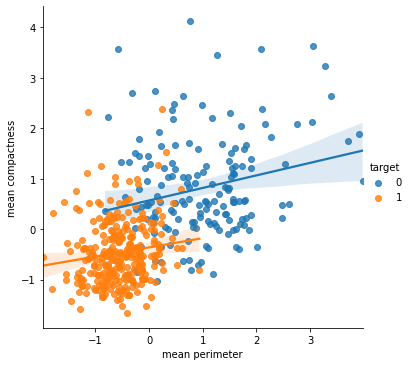

In [26]:
## Visualizing two features of the standardized data ##

ax = sns.lmplot(x='mean perimeter', y='mean compactness', hue='target', data=df_train)

plt.show()

**Question 12**: In one figure plot all the pairs available in this set of features for different target classes: `mean radius`, `mean texture`, `mean perimeter`, `mean compactness`, `mean concavity`, `mean fractal dimension`, `target`. Make sure that the regression lines are plotted as well. Use Seaborn library for this purpose and have a look at this: https://seaborn.pydata.org/generated/seaborn.pairplot.html.

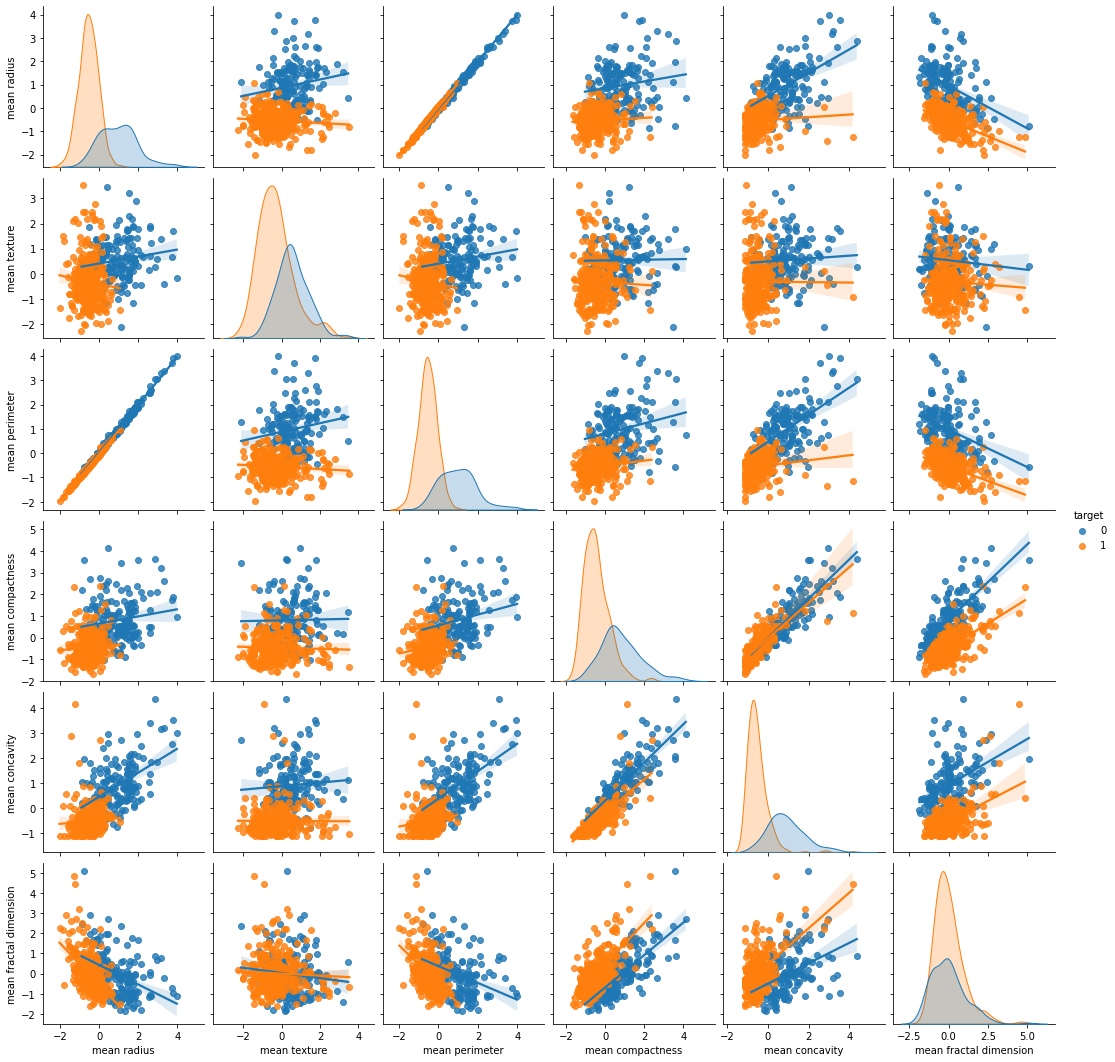

In [27]:
## Visualizing pairplots for multiple features of the standardized data ##

sns.pairplot(df_train[['mean radius', 'mean texture', 'mean perimeter', 'mean compactness', 'mean concavity', 'mean fractal dimension', 'target']], hue='target', kind='reg')
plt.show()

# Part 2: Using All Features

Considering the fact that some features are highly correlated with each other and some features are less correlated with the target, it is more efficient to do feature selection or feature extraction before training our model. We will explore those things in part 3, 4 and 5. In part 2 we use the full training data to do hyperparameter tuning and train our model. First, for different number of neighbors in KNN, $k=\{1, 2, \ldots, 100\}$ model is trained using training data and the test (accuracy) score is reported and plotted. In the next step, `cross_val_score` is used for performing cross-validation in a loop over different number of neighbors. Then the mean cross-validation accuracy score is plotted in terms of the number of neighbors in KNN and the test score is reported for the optimum number of neighbors (based on cross-validation scores). Finally, only using `GridSearchCV` cross-validation is performed and the optimum number of neighbors is found for which the test score is reported as well. In this project number of cross-validation folds is denoted by `cv` which is set to be equal to `5`.

Useful resources for this section:

1- KNN: 

https://www.youtube.com/watch?v=HVXime0nQeI&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=35

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

2- Cross-validation and grid search:

https://www.youtube.com/watch?v=fSytzGwwBVw&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=2

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



## Part 2.1: KNN without cross-validation 

**Question 13**: Write a function to a create KNN classifier and train the model for the number of neighbors `k={1, 2, ..., 100}`. Evaluate the test score for each specific number of neighbors. This function should return the maximum test score and the number of neighbors associated with that, in addition to a list of test scores for different number of neighbors. 

In [25]:
## KNN without cross-validation ##

def KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  '''

  test_scores = []  # To save test scores for different number of neighbors in KNN

  for i in N_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)  # Create KNN classifier
    knn.fit(X_train, y_train)  # Train the model using the training set

    # Method 1: Calculating accuracy using accuracy_score
    # y_pred = knn.predict(X_test)  # Predict the response for test dataset
    # test_score = accuracy_score(y_test, y_pred)
    # test_scores.append(test_score)
    # print('K = {}, Test accuracy : {} or approximately {}%'.format(i, test_score, int(round(test_score*100))))  # Model accuracy

    # Method 2: Calculating accuracy using knn.score
    test_score = knn.score(X_test, y_test)
    test_scores.append(test_score)
    # print('K = {}, Test accuracy : {} or approximately {}% \n'.format(i, test_score, int(round(test_score*100))))  # Model accuracy
  
  max_test_score = max(test_scores)
  K_opt = N_neighbors[test_scores.index(max_test_score)] #I think this gives incorrect value for K_opt (K-opt + 1), in my code I use K_opt = test_scores.index(max(test_scores)) which gives better results on the test set.

  return max_test_score, K_opt, test_scores

In [29]:
##(Nils version), KNN without cross-validation ##

def KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  '''
  

  test_scores = [] # To save test scores for different number of neighbors in KNN


  for i in N_neighbors:
    
    neigh = KNeighborsClassifier(n_neighbors= i)    # Create KNN classifier
    
    neigh_fit = neigh.fit(X_train, y_train)    # Train the model using the training set

    
    test_score = neigh_fit.score(X_test, y_test)   # Calculate accuracy using knn.score
    test_scores.append(test_score)
  
  max_test_score = max(test_scores)
  K_opt = test_scores.index(max_test_score)

  return max_test_score, K_opt, test_scores

**Qestion 14**: Plot test scores for different number of neighbors.

The best test score for KNN without cross-validation and without feature seletion/extraction is 0.9736842105263158 which is for K=16 number of neighbors. 




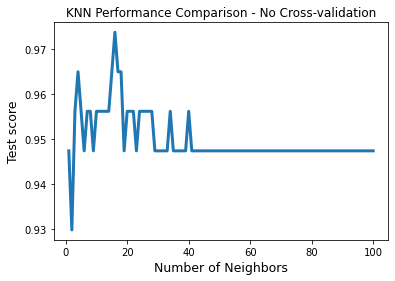

In [26]:
## Plot test scores for different number of neighbours without cross-validation ##

N_neighbors = np.arange(1, 101, 1)  # Array of neighbors
max_test_score, K_opt, test_scores = KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test)

print('The best test score for KNN without cross-validation and without feature seletion/extraction is {} which is for K={} number of neighbors. \n\n'.format(max_test_score, K_opt))

plt.plot(N_neighbors, test_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5) 
plt.ylabel('Test score', fontsize=12.5) 
plt.title('KNN Performance Comparison - No Cross-validation', fontsize=12) 
plt.show()

The best test score for KNN without cross-validation and without feature seletion/extraction is 0.9736842105263158 which is for K=15 number of neighbors. 




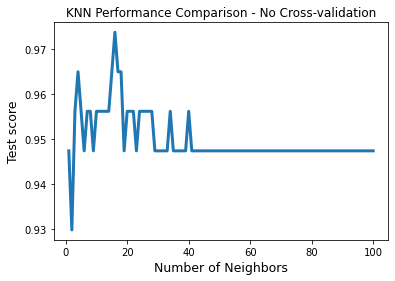

In [30]:
## (Nils version) Plot test scores for different number of neighbours without cross-validation ##

N_neighbors = np.arange(1, 101, 1)  # Array of neighbors
max_test_score, K_opt, test_scores = KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test)

print('The best test score for KNN without cross-validation and without feature seletion/extraction is {} which is for K={} number of neighbors. \n\n'.format(max_test_score, K_opt))

plt.plot(N_neighbors, test_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5) 
plt.ylabel('Test score', fontsize=12.5) 
plt.title('KNN Performance Comparison - No Cross-validation', fontsize=12) 
plt.show()

## Part 2.2: KNN with cross-validation

**Question 15**: Write a function which (for different number of neighbors) creates a KNN classifier, calculates the mean of cross validation scores (obtained using `cross_val_score`) and creates a list for the means, then calculates the maximum of this list and the corresponding number of neighbors in addition to the test score for that. 

In [23]:
## KNN with k-fold cross-validation ##

def KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  cv: number of folds in cross-validation
  '''

  mean_cv_scores = []  # For saving the average of cross-validation scores

  for i in N_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)  # Create KNN classifier
    scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')  # scoring, if None the estimator’s default scorer (if available) is used
    scores_mean = scores.mean()
    mean_cv_scores.append(scores_mean)

    # print('K = {}'.format(i))
    # print('Scores = {}'.format(scores))
    # print('Average score = {} or approximately {}%\n'.format(scores_mean, int(round(scores_mean*100))))

  max_cv_score = max(mean_cv_scores)  # The best cross-validation score
  K_opt = N_neighbors[mean_cv_scores.index(max_cv_score)]  # #I think this gives incorrect value for K_opt (K-opt + 1), in my code I use K_opt = test_scores.index(max(test_scores)) which gives better results on the test set
  test_score, _, _ = KNN_without_CV([K_opt], X_train, X_test, y_train, y_test)  # Finding the test score based on the best number of neighbors found using cross-validation

  return max_cv_score, K_opt, mean_cv_scores, test_score

In [107]:
## (Nils), KNN with k-fold cross-validation ##

def KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  cv: number of folds in cross-validation
'''

  mean_cv_scores = []  # For saving the average of cross-validation scores
    
  for i in N_neighbors:
    
      neigh = KNeighborsClassifier(n_neighbors= i)    # Create KNN classifier
    
      cross_val = cross_val_score(neigh, X_train, y_train, cv = cv, scoring = 'accuracy')

      mean_cv_scores.append(cross_val.mean())
    
     
  max_cv_score = max(mean_cv_scores) 
   
  K_opt = mean_cv_scores.index(max_cv_score)  
  #K_opt = N_neighbors[mean_cv_scores.index(max_cv_score)]

  KNN_opt = KNeighborsClassifier(K_opt).fit(X_train, y_train)

  test_score = KNN_opt.score(X_test, y_test)



  

  return max_cv_score, K_opt, mean_cv_scores, test_score

In [109]:
mean_cv_scores.index(max_cv_score) 


4

**Question 16**: Plot (the mean) cross-validation scores for different number of neighbors and `cv=5`. 

The best number of neighbors for KNN based on 5-fold cross-validation and without feature seletion/extraction is K=5 for which cross-validation score is 0.9648351648351647 and the test score is 0.956140350877193. 




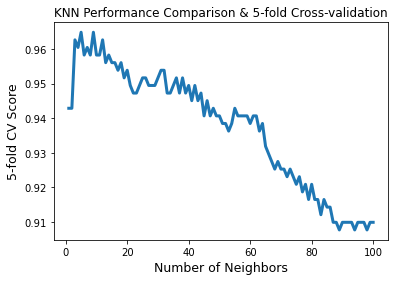

In [24]:
## Plot cross-validation scores for different number of neighbours ##

cv = 5  # Number of folds in cross-validation
max_cv_score, K_opt, mean_cv_scores, test_score = KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test)  # Finding the best number of neighbors based on the best cross-validation score

print('The best number of neighbors for KNN based on {}-fold cross-validation and without feature seletion/extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

The best number of neighbors for KNN based on 5-fold cross-validation and without feature seletion/extraction is K=4 for which cross-validation score is 0.9648351648351647 and the test score is 0.9649122807017544. 




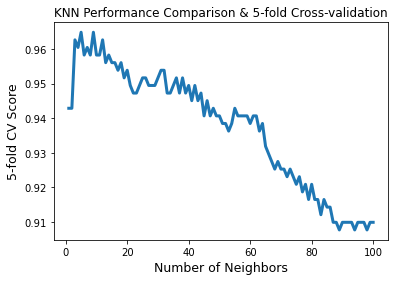

In [108]:
## (Nils), Plot cross-validation scores for different number of neighbours ##

cv = 5  # Number of folds in cross-validation
max_cv_score, K_opt, mean_cv_scores, test_score = KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test)  # Finding the best number of neighbors based on the best cross-validation score

print('The best number of neighbors for KNN based on {}-fold cross-validation and without feature seletion/extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

## Part 2.3: KNN with cross-validation using GridSearchCV

**Question 17**: Repeat the previous section and use `GridSearchCV` instead of `cross_val_score`.

In [33]:
## KNN with k-fold cross-validation using GridSearchCV ##

def KNN_GridSearch(N_neighbors, cv, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  cv: number of folds in cross-validation
  '''

  knn = KNeighborsClassifier()  # Create KNN classifier
  param_grid = {'n_neighbors': N_neighbors}  # Dictionary with parameters names (str) as keys and lists of parameter settings to try as values
  GridSearch = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)  # Using GridSearchCV for cross-validation
  GridSearch.fit(X_train, y_train)  # Train the model using the training set

  ## All the cross-validation scores, optimum number of neighbors and test score for that is calculated using GridSearchCV ##

  mean_cv_scores = GridSearch.cv_results_['mean_test_score']  # Average of cross-validation scores
  max_cv_score = GridSearch.best_score_  # The best cross-validation score
  K_opt = GridSearch.best_params_['n_neighbors'] #I think this gives incorrect value for K_opt (K-opt + 1), in my code I use K_opt = test_scores.index(max(test_scores)) which gives better results on the test set
  test_score = GridSearch.score(X_test, y_test)  # Finding the test score based on the best number of neighbors found using cross-validation

  return max_cv_score, K_opt, mean_cv_scores, test_score

The best number of neighbors for KNN based on 5-fold cross-validation and without feature seletion/extraction is K=5 for which cross-validation score is 0.9648351648351647 and the test score is 0.956140350877193. 




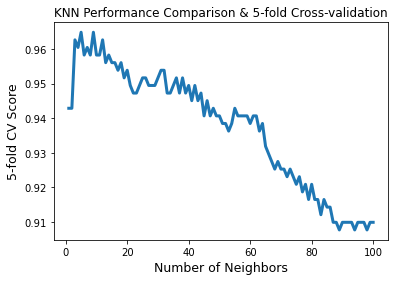

In [34]:
## Plot cross-validation scores for different number of neighbours using GridSearchCV ##

max_cv_score, K_opt, mean_cv_scores, test_score = KNN_GridSearch(N_neighbors, cv, X_train, X_test, y_train, y_test)

print('The best number of neighbors for KNN based on {}-fold cross-validation and without feature seletion/extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)   
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

In [51]:
## (Nils version), KNN with k-fold cross-validation using GridSearchCV ##

def KNN_GridSearch(N_neighbors, cv, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  cv: number of folds in cross-validation
  '''
  mean_cv_scores = []  # For saving the average of cross-validation scores
    
  N_neighbors = np.arange(1, 101, 1)
  param_grid = {'n_neighbors': N_neighbors} 

  grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv = cv) #change to grid search
  grid_search.fit(X_train, y_train)
    
  mean_cv_scores = []
  for j in range(len(grid_search.cv_results_['mean_test_score'])):
 
     mean_cv_scores.append(grid_search.cv_results_['mean_test_score'][j])
    
     
  max_cv_score = max(mean_cv_scores) 
   
  K_opt = mean_cv_scores.index(max(mean_cv_scores))  

  KNN_opt = KNeighborsClassifier(K_opt).fit(X_train, y_train)

  test_score = KNN_opt.score(X_test, y_test)


  return max_cv_score, K_opt, mean_cv_scores, test_score

The best number of neighbors for KNN based on 5-fold cross-validation and without feature seletion/extraction is K=4 for which cross-validation score is 0.9648351648351647 and the test score is 0.9649122807017544. 




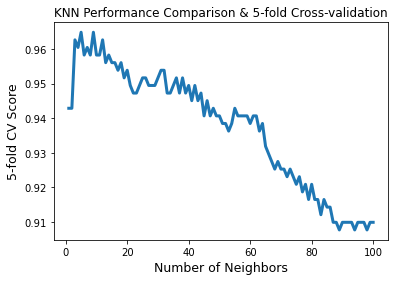

In [52]:
## (Nils version) Plot cross-validation scores for different number of neighbours using GridSearchCV ##

N_neighbors = np.arange(1, 101, 1)
param_grid = {'n_neighbors': N_neighbors} 

max_cv_score, K_opt, mean_cv_scores, test_score = KNN_GridSearch(param_grid, cv, X_train, X_test, y_train, y_test)

print('The best number of neighbors for KNN based on {}-fold cross-validation and without feature seletion/extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)   
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

# Part 3: Feature Selection

As demonstrated in the visualization section, some features in our dataset are highly correlated and using all of them will make our model inefficient. Therefore, in this section a function named `OrderCorr` is designed for performing feature selection based on correlation. First, it orders all the features based on correlation with the target, then it drops those which are poorly correlated with the target. Finally, from each two highly correlated features, the one with less correlation with the target is dropped. 

**Question 18:** Define a function named `Heatmap` for creating a nice heatmap of our dataframe using the training data. 

You may find the following resources useful:

1- https://towardsdatascience.com/formatting-tips-for-correlation-heatmaps-in-seaborn-4478ef15d87f

2- https://seaborn.pydata.org/generated/seaborn.heatmap.html

3- https://seaborn.pydata.org/examples/many_pairwise_correlations.html

In [15]:
## Function to create heatmap of correlation between columns of df ##

def Heatmap(df):

  Correlation = df.corr()
  
  mask = np.triu(np.ones_like(Correlation, dtype=np.bool))  # Generate a mask for the upper triangle
  cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Generate a custom diverging colormap

  with sns.axes_style('white'):
    ax = plt.figure(figsize=(.9*len(Correlation), .5*len(Correlation)))
    ax = sns.heatmap(Correlation, mask=mask, cmap=cmap, linewidths=.5, annot=True) #, annot_kws={'size': 24})

    _, xlabels = plt.xticks()
    ax.set_xticklabels(xlabels, size=11.5)
    _, ylabels = plt.yticks()
    ax.set_yticklabels(ylabels, size=11.5)

In [14]:
## (Nils version) Function to create heatmap of correlation between columns of df ##

def Heatmap(df):
    
    
    Correlation_matrix = df.corr()
    plt.figure(figsize=(25,25))
    mask = np.triu(np.ones(Correlation_matrix.shape)).astype(np.bool)
    sns.heatmap(Correlation_matrix, mask = mask, linewidths = 0.5, annot = True)

In [35]:
## Create a datafram (including only the training data) for feature section ##

df_train = pd.concat([X_train.set_index(y_train.index), y_train], axis=1)  # The set_index command is used to make sure index of X_train is the same as y_train

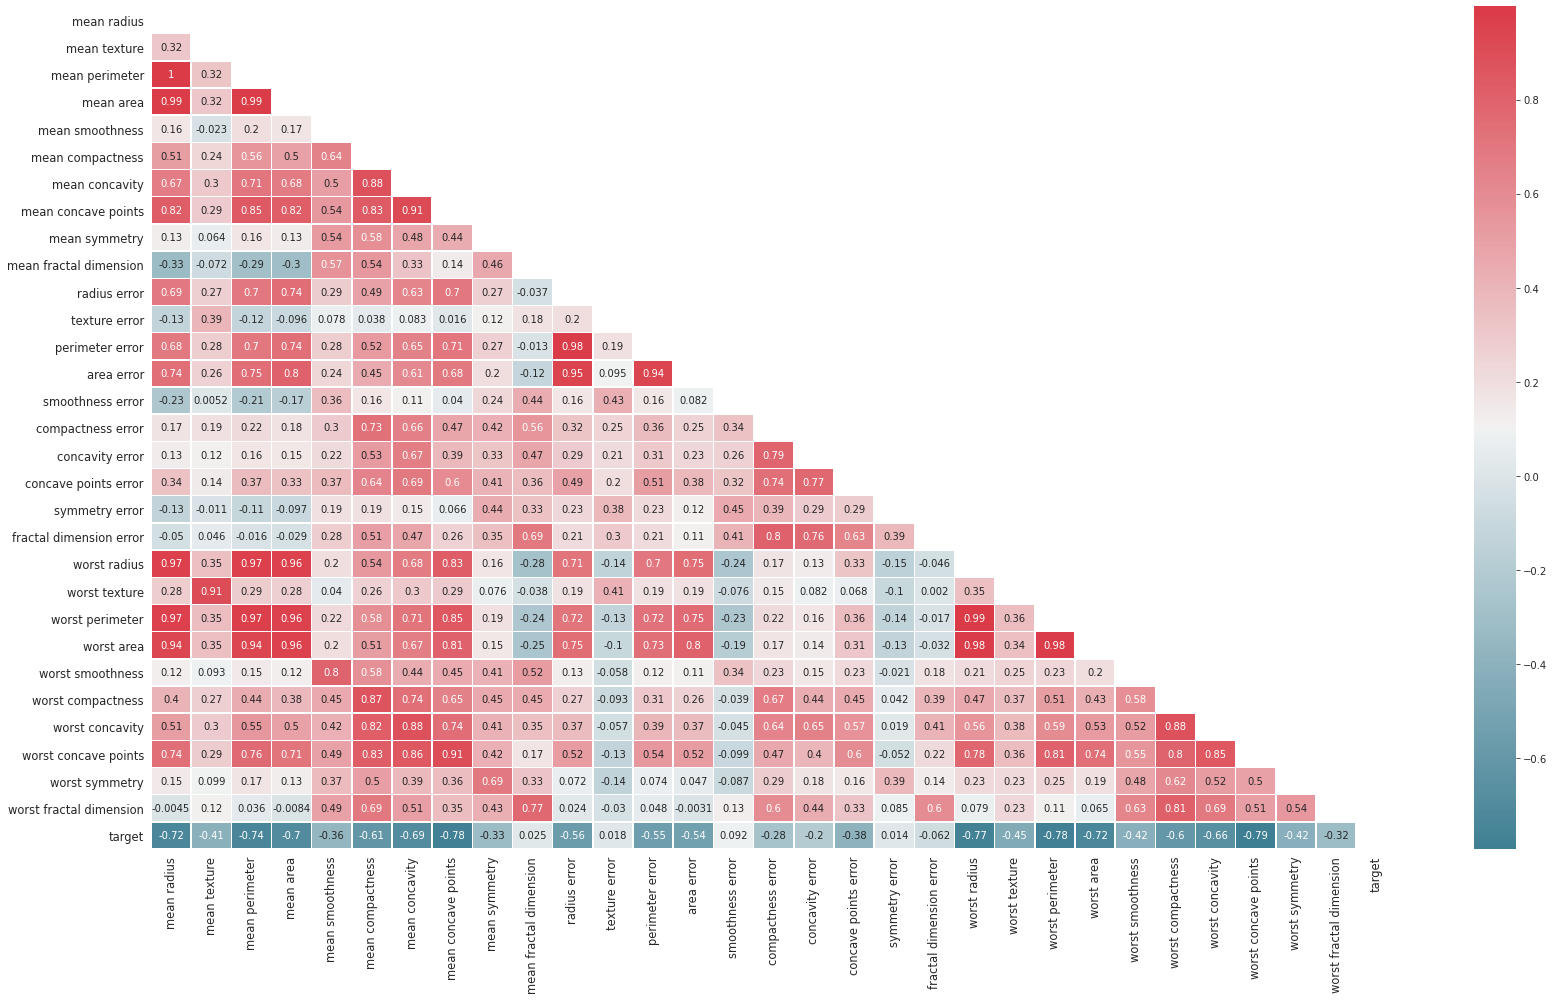

In [36]:
Heatmap(df_train)  

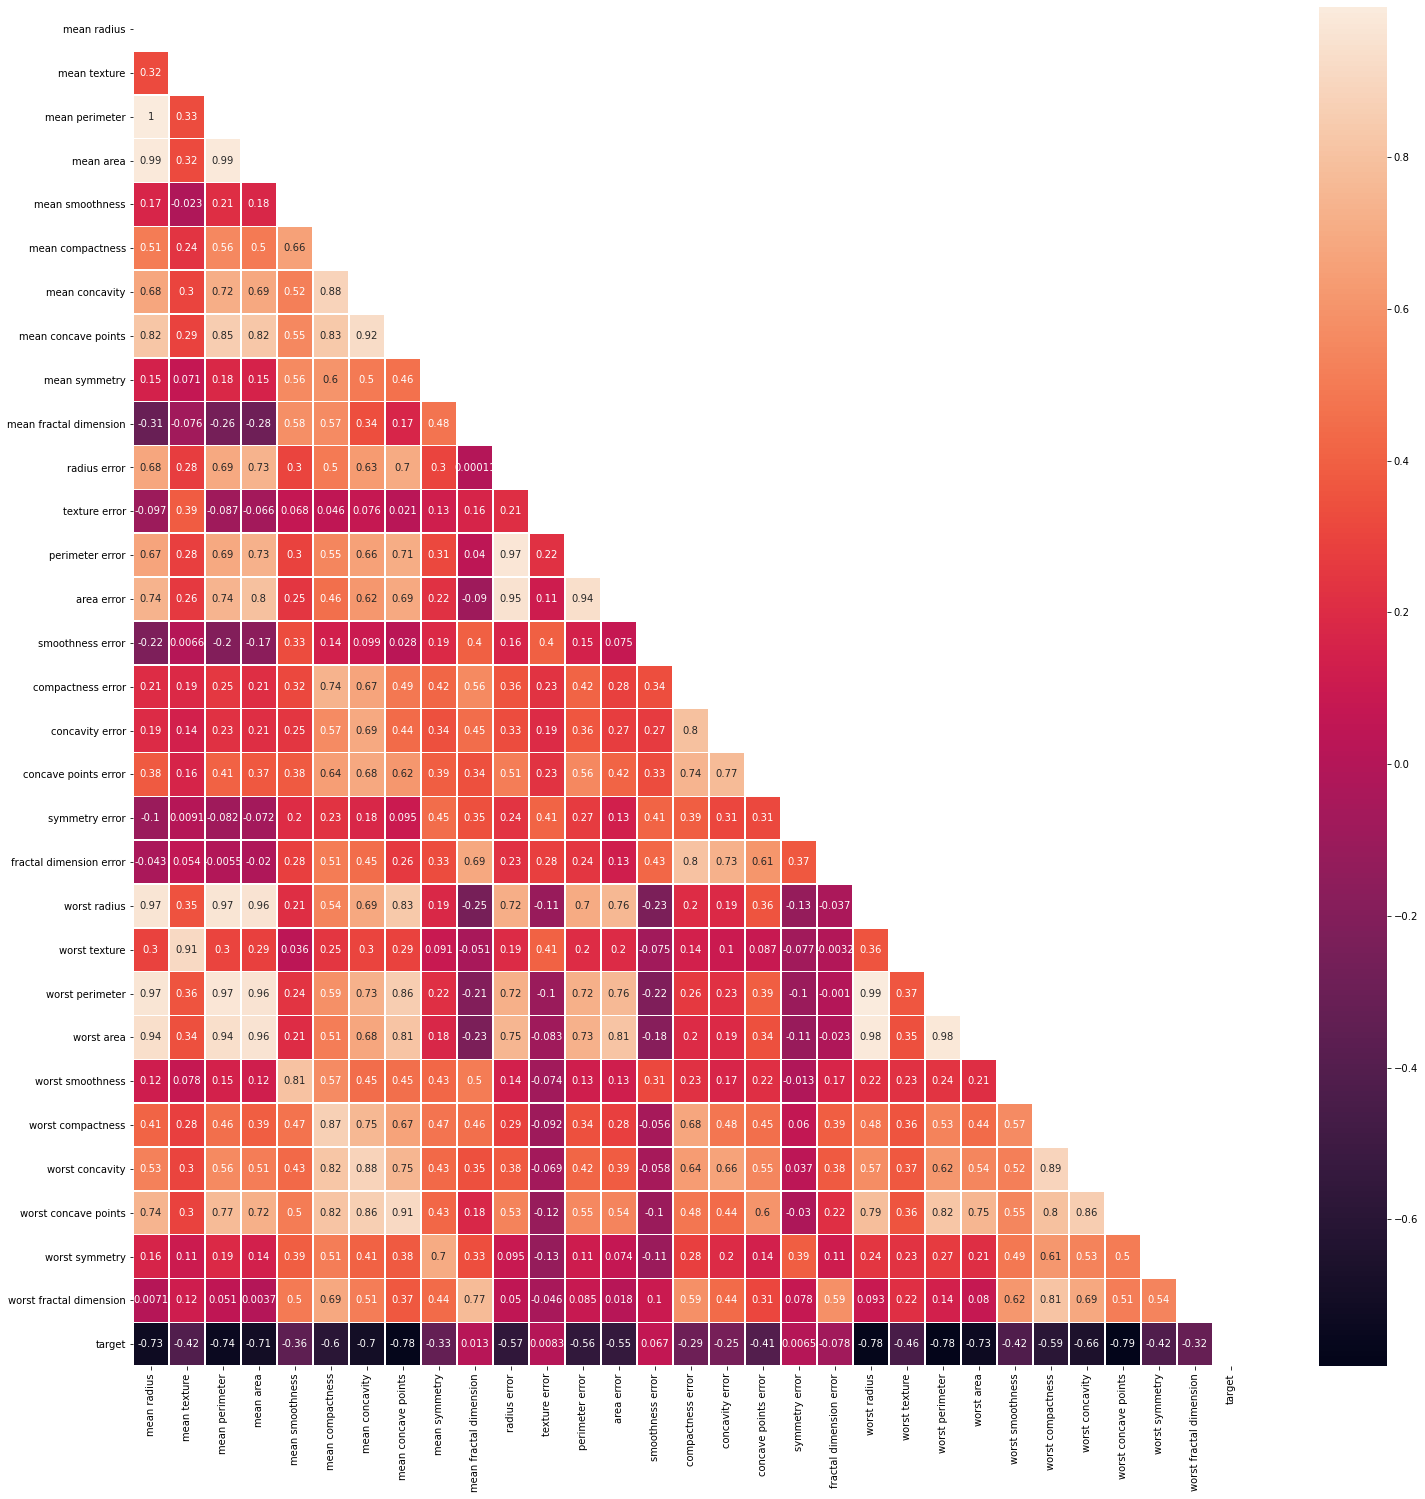

In [15]:
#Nils version
Heatmap(df)

It is clear from the heatmap that some features like `symmetry error` and `texture error` are poorly correlated with the target. Also features like `mean perimeter` and `mean area` are highly correlated with each other. In function `OrderCorr` first features are ordered based on the correlation with the target. Then two different thresholds are defined. Each feature which has a correlation with the target less than or equal to `threshold1` is dropped. Finally from each two features which has a correlation larger than `threshold2` the one which has weaker correlation with the target is dropped.  

**Question 19:** Define a function named `OrderCorr` for feature selection as described above.

In [16]:
## Function for feature selection based on correlation ##
## First, features are ordered based on correlation with target variable ##
## Then, from each two features which are highly correlated the one with lower correlation with the target is dropped ##

def OrderCorr(df, target, threshold1=0, threshold2=0.9):
  '''
  df: dataframe   
  target: target variable
  threshold1: correlation between each remaining feature and the target must be larger than this threshold
  threshold2: if correlation between each two feature is larger than this threshold one of them (the one with lower correlation with the target) is dropped
  '''

  Correlation = df.corr()  # Correlation dataframe

  # Ordering features based on correlation with the target #

  Correlation['target abs'] = Correlation[target].abs()  # Absolute value of target in a new column
  Correlation.sort_values(by='target abs', ascending=False, inplace=True)  # Sorting the dataframe based on the absolute value of correlation with target
  Corr_with_target = Correlation[[target]]  # A new dataframe including only 'target'
  Corr_with_target.drop([target], inplace=True)  # Eliminating unnecessary rows

  # Dropping features with smaller correlation with the target #

  Corr_with_target1 = Corr_with_target.copy()  # Creating a copy of dataframe
  Corr_with_target1 = Corr_with_target1[abs(Corr_with_target1[target]) > threshold1]

  # Dropping one of each two highly correlated features #

  for i, feature1 in enumerate(Corr_with_target.index):
    for feature2 in Corr_with_target.index[i+1:]:
      if (feature1 and feature2) in Corr_with_target1.index and abs(Correlation.loc[feature1, feature2]) > threshold2:
        Corr_with_target1.drop([feature2], inplace=True)  # Eliminating unnecessary rows

  Corr_with_target1.rename(columns={target: 'Correlation with ' + target}, inplace=True)
  print(Corr_with_target1.to_string(justify='center'))  # Displaying the selected features and their correlation with the target

  return Corr_with_target1

In [55]:
# (Nils version)
# Function for feature selection based on correlation ##
## First, features are ordered based on correlation with target variable ##
## Then, from each two features which are highly correlated the one with lower correlation with the 
#target is dropped ##



def OrderCorr(data, target, treshold1, treshold2):
    
    
    l = []
    
    for i in range(len(data.columns)-1):
            
        l.append([abs(data.iloc[:, i].corr(target)), data.columns[i]])
        
    new_indices = sorted(l, key=lambda x: abs(x[0]), reverse = True)
    
    data_sorted = pd.DataFrame()
    
    for i in range(len(new_indices)):
        
        data_sorted = data_sorted.append(data[new_indices[i][1]])

    dfs = data_sorted.transpose()    

    drop1 = []
    
    for i in range(len(dfs.columns)):
        
        if  abs(dfs.iloc[:, i].corr(target))  < treshold1:
            
            drop1.append(dfs.columns[i])
    

    features_sorted = dfs.drop(drop1, 1)


    drop2 = []

    w = list(itertools.combinations(features_sorted.columns, 2))    # creates a list of lists with indices for all pairs of features 
    
    for j in range(len(w)):
        
        if abs(features_sorted[w[j][0]].corr(features_sorted[w[j][1]])) > treshold2:
            
            if abs(features_sorted[w[j][0]].corr(target)) < abs(features_sorted[w[j][1]].corr(target)):    # for each pair of highly corellated features, check which is most correlated with target, delete the other
                
                if  w[j][0] not in drop2:
                
                    drop2.append( w[j][0] )
                
            else: 
                
                if  w[j][1] not in drop2:
                    
                    drop2.append( w[j][1] )


    data_out = features_sorted.drop(drop2, 1)
    
    print("number of selected features =", len(data_out.columns))
    print("correlation with target:")
    for i in range(len(data_out.columns)):
        print(data_out.columns[i], ":", data_out[data_out.columns[i]].corr(target))

    
    return data_out.transpose()

    

Training data is used for feature selection based on correlation. As seen bellow, using `threshold1=0.37` and `threshold2=0.90`, ten features are left in the dataframe which should make our model more efficient and enough accurate. 

In [38]:
Corr_with_target = OrderCorr(df_train, target='target', threshold1=0.37, threshold2=0.9)

                      Correlation with target
worst concave points        -0.793440        
worst perimeter             -0.775844        
worst concavity             -0.655823        
mean compactness            -0.612290        
worst compactness           -0.598603        
radius error                -0.562805        
worst texture               -0.452060        
worst smoothness            -0.420424        
worst symmetry              -0.417622        
concave points error        -0.382164        


In [56]:
Corr_with_target = OrderCorr(df_train, df['target'], 0.37, 0.9) #Nils version

number of selected features = 10
correlation with target:
worst concave points : -0.7934404959006442
worst perimeter : -0.7758444114199657
worst concavity : -0.6558233550199014
mean compactness : -0.6122899148326321
worst compactness : -0.5986030394631712
radius error : -0.5628050304698871
worst texture : -0.45205988833548133
worst smoothness : -0.4204236723631302
worst symmetry : -0.4176216333973384
concave points error : -0.3821642507984811


Here training and test data are updated so that they only include the selected features which are going to be used in the next steps of Part 3 of this project. 

In [57]:
X_train = X_train[Corr_with_target.index].set_index(y_train.index)  # Creating a new X_train including only the selected features
X_test = X_test[Corr_with_target.index].set_index(y_test.index)  # Creating a new X_test including only the selected features

Then a training data including only the new selected features is created. As seen in the heatmap of the new training dataset all the features have a minimum amount of correlation with the target and are not strongly correlated with each other (`threshold1=0.37` and `threshold2=0.90`). 

In [40]:
## Create a datafram (including only the training data) for feature section ##

df_train = pd.concat([X_train.set_index(y_train.index), y_train], axis=1)

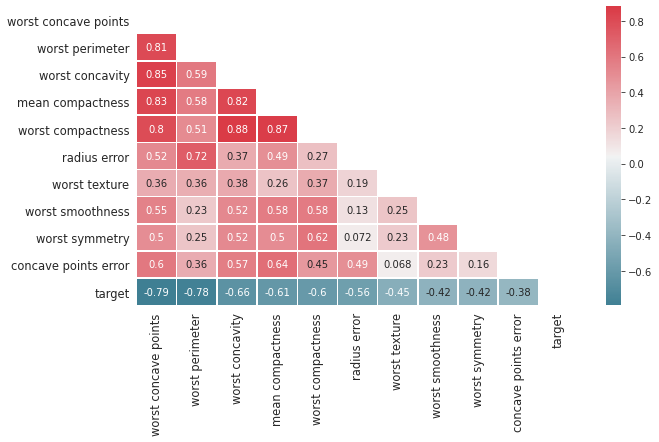

In [41]:
Heatmap(df_train)

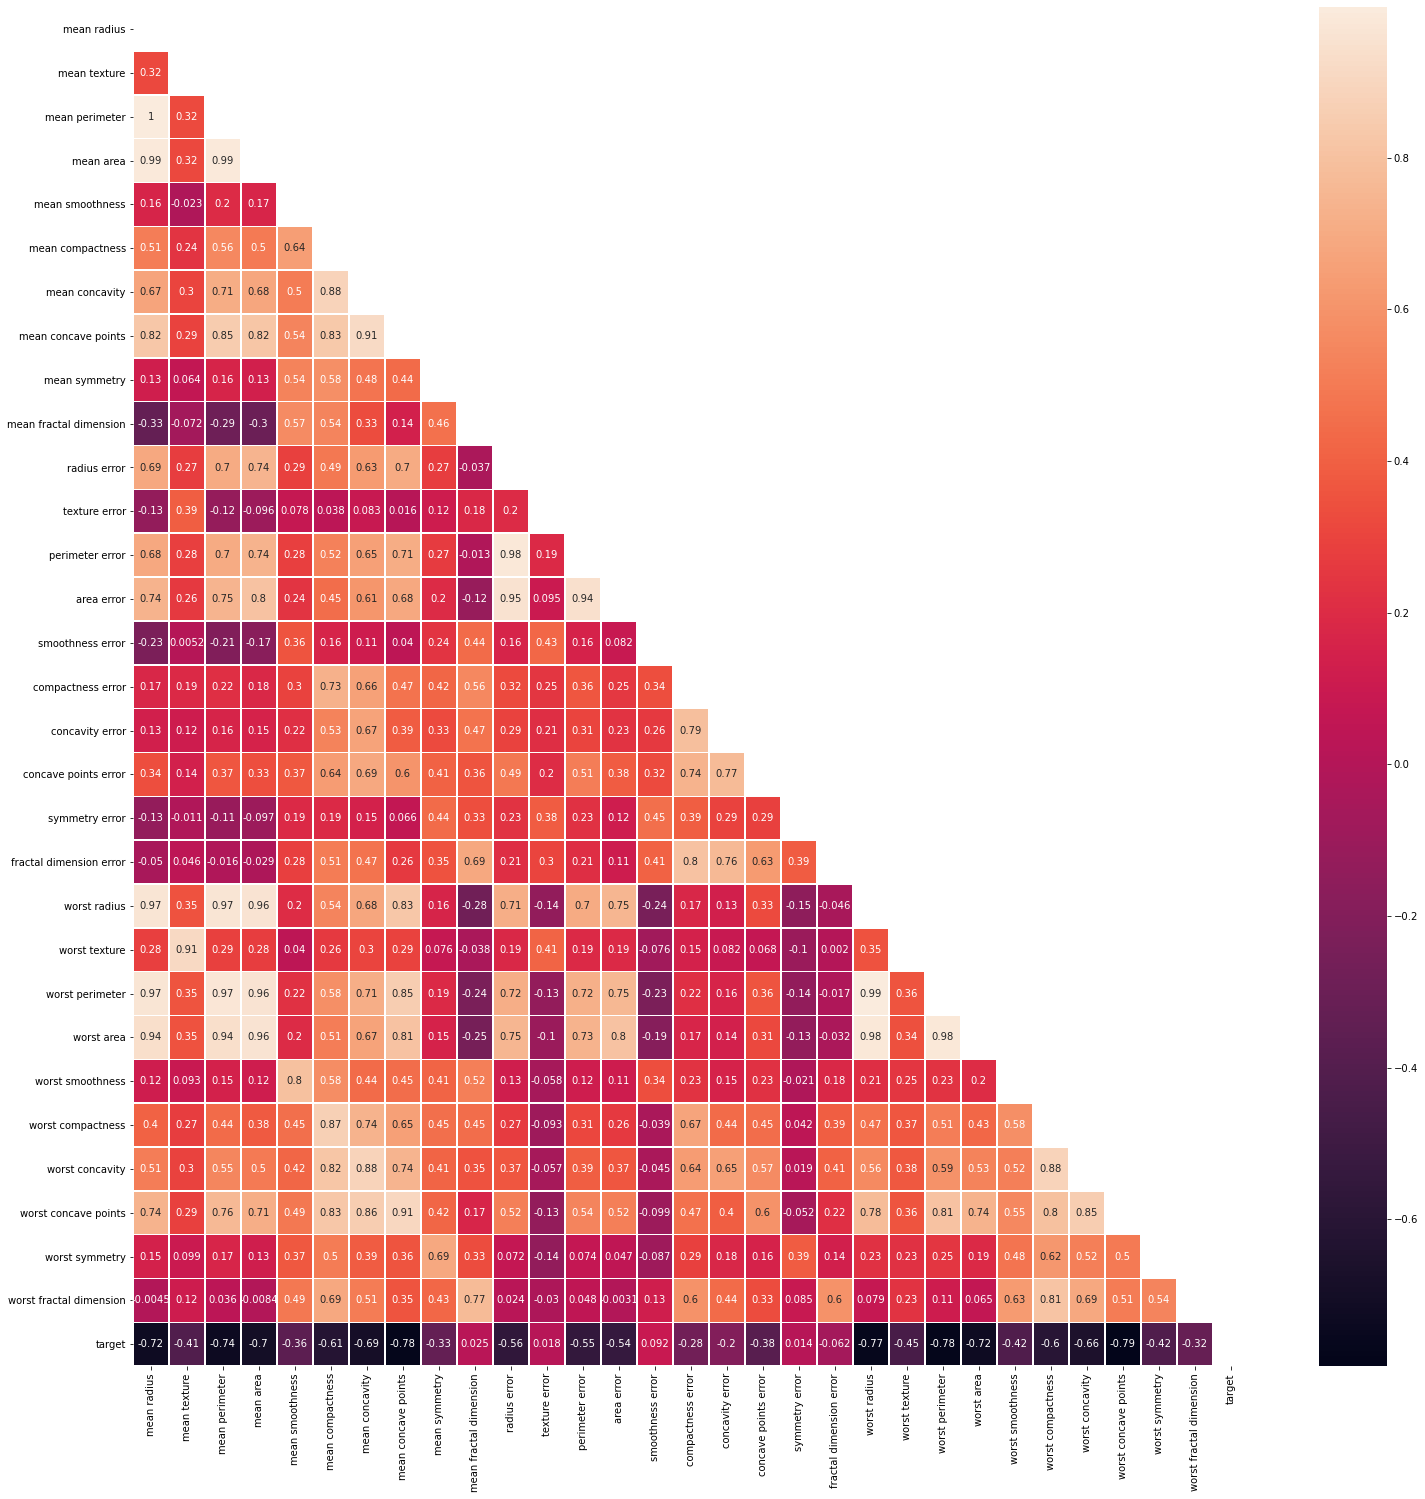

In [16]:
Heatmap(df_train)

Similar to part 2, here after feature selection in 3 sections KNN is used for predicting breast cancer. The first section is without cross-validation, the second section includes cross-validation using `cross_val_score` in a loop, and the last section of part 3 presents the results of performing cross-validation using `GridSearchCV` without using a loop. 

## Part 3.1: KNN without cross-validation after feature selection

**Question 20:** Use the function created in part 2 for KNN without cross validation to find test scores for different number of neighbors. The only difference with part 2 is that here the dataframe includes only the selected features. Plot the test score in terms of the number of neighbors.

The best test score for KNN without cross-validation after feature selection is 0.9473684210526315 which is for K=1 number of neighbors. 




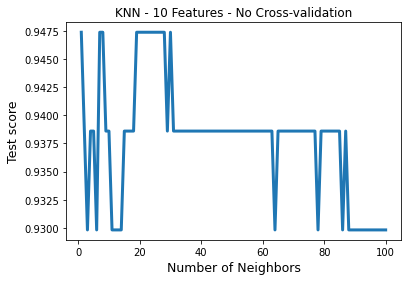

In [42]:
## Plot test scores for different number of neighbours after feature selection without cross-validation ##

N_features = X_train.shape[1]  # Number of features

N_neighbors = np.arange(1, 101, 1)  # Array of neighbors
max_test_score, K_opt, test_scores = KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test)

print('The best test score for KNN without cross-validation after feature selection is {} which is for K={} number of neighbors. \n\n'.format(max_test_score, K_opt))

plt.plot(N_neighbors, test_scores, linewidth = 3) 
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('Test score', fontsize=12.5)  
plt.title('KNN - {} Features - No Cross-validation'.format(N_features), fontsize=12) 
plt.show() 

In [39]:
#Nils

def KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  '''

  test_scores = []  # To save test scores for different number of neighbors in KNN

  for i in N_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)  # Create KNN classifier
    knn.fit(X_train, y_train)  # Train the model using the training set

    # Method 1: Calculating accuracy using accuracy_score
    # y_pred = knn.predict(X_test)  # Predict the response for test dataset
    # test_score = accuracy_score(y_test, y_pred)
    # test_scores.append(test_score)
    # print('K = {}, Test accuracy : {} or approximately {}%'.format(i, test_score, int(round(test_score*100))))  # Model accuracy

    # Method 2: Calculating accuracy using knn.score
    test_score = knn.score(X_test, y_test)
    test_scores.append(test_score)
    # print('K = {}, Test accuracy : {} or approximately {}% \n'.format(i, test_score, int(round(test_score*100))))  # Model accuracy
  
  max_test_score = max(test_scores)
  K_opt = N_neighbors[test_scores.index(max_test_score)]

  return max_test_score, K_opt, test_scores

The best test score for KNN without cross-validation and without feature seletion/extraction is 0.9736842105263158 which is for K=16 number of neighbors. 




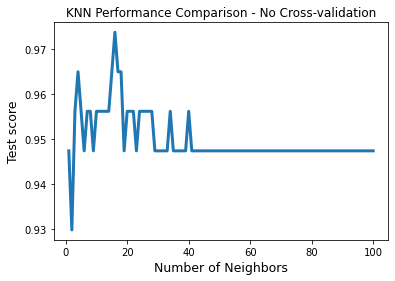

In [40]:
## Nils, Plot test scores for different number of neighbours after feature selection without cross-validation ##

N_neighbors = np.arange(1, 101, 1)  # Array of neighbors
max_test_score, K_opt, test_scores = KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test)

print('The best test score for KNN without cross-validation and without feature seletion/extraction is {} which is for K={} number of neighbors. \n\n'.format(max_test_score, K_opt))

plt.plot(N_neighbors, test_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5) 
plt.ylabel('Test score', fontsize=12.5) 
plt.title('KNN Performance Comparison - No Cross-validation', fontsize=12) 
plt.show()

## Part 3.2: KNN with cross-validation after feature selection

**Question 21:** Use the function created in part 2 for KNN with cross validation to find mean cross-validation scores for different number of neighbors. The only difference with part 2 is that here the dataframe includes only the selected features. Plot the mean cross-validation scores in terms of the number of neighbors.

The best number of neighbors for KNN based on 5-fold cross-validation after feature selection is K=3 for which cross-validation score is 0.9538461538461538 and the test score is 0.9298245614035088. 




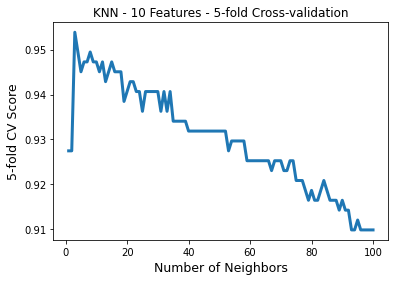

In [43]:
## Plot cross-validation scores for different number of neighbours after feature selection##

max_cv_score, K_opt, mean_cv_scores, test_score = KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test)  # Finding the best number of neighbors based on the best cross-validation score

print('The best number of neighbors for KNN based on {}-fold cross-validation after feature selection is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5) 
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN - {} Features - {}-fold Cross-validation'.format(N_features, cv), fontsize=12)
plt.show() 

The best number of neighbors for KNN based on 5-fold cross-validation and without feature seletion/extraction is K=5 for which cross-validation score is 0.9648351648351647 and the test score is 0.956140350877193. 




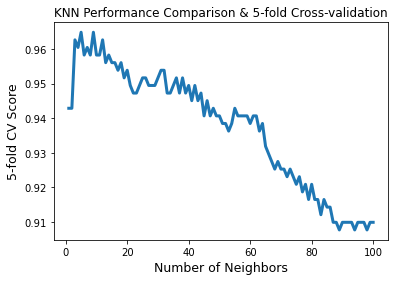

In [41]:
## Nils, Plot cross-validation scores for different number of neighbours after feature selection##
cv = 5  # Number of folds in cross-validation
max_cv_score, K_opt, mean_cv_scores, test_score = KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test)  # Finding the best number of neighbors based on the best cross-validation score

print('The best number of neighbors for KNN based on {}-fold cross-validation and without feature seletion/extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show()

## Part 3.3: KNN with cross-validation using GridSearchCV after feature selection

**Question 22:** Use the function created in part 2 for KNN with cross validation using GridSearchCV to find mean cross-validation scores for different number of neighbors. The only difference with part 2 is that here the dataframe includes only the selected features. Plot the mean cross-validation scores in terms of the number of neighbors.

The best number of neighbors for KNN based on 5-fold cross-validation after feature seletion is K=3 for which cross-validation score is 0.9538461538461538 and the test score is 0.9298245614035088. 




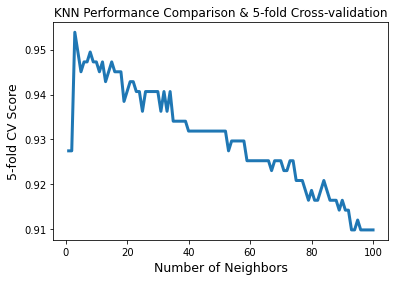

In [44]:
## Plot cross-validation scores for different number of neighbours using GridSearchCV after feature selection ##

max_cv_score, K_opt, mean_cv_scores, test_score = KNN_GridSearch(N_neighbors, cv, X_train, X_test, y_train, y_test)

print('The best number of neighbors for KNN based on {}-fold cross-validation after feature seletion is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3) 
plt.xlabel('Number of Neighbors', fontsize=12.5) 
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5) 
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12) 
plt.show()

In [53]:
## Nils, KNN with k-fold cross-validation using GridSearchCV ##

def KNN_GridSearch(N_neighbors, cv, X_train, X_test, y_train, y_test):
  '''
  N_neighbors: array of number of neighbors
  cv: number of folds in cross-validation
  '''
  mean_cv_scores = []  # For saving the average of cross-validation scores
    
  N_neighbors = np.arange(1, 101, 1)
  param_grid = {'n_neighbors': N_neighbors}     

  grid_search = GridSearchCV(KNeighborsClassifier(), N_neighbors, cv = cv) 
  grid_search.fit(X_train, y_train)
    
  mean_cv_scores = []
  for j in range(len(grid_search.cv_results_['mean_test_score'])):
 
     mean_cv_scores.append(grid_search.cv_results_['mean_test_score'][j])
    
     
  max_cv_score = max(mean_cv_scores) 
   
  K_opt = mean_cv_scores.index(max(mean_cv_scores))  

  KNN_opt = KNeighborsClassifier(K_opt).fit(X_train, y_train)

  test_score = KNN_opt.score(X_test, y_test)


  return max_cv_score, K_opt, mean_cv_scores, test_score

The best number of neighbors for KNN based on 5-fold cross-validation and without feature seletion/extraction is K=2 for which cross-validation score is 0.9538461538461538 and the test score is 0.9385964912280702. 




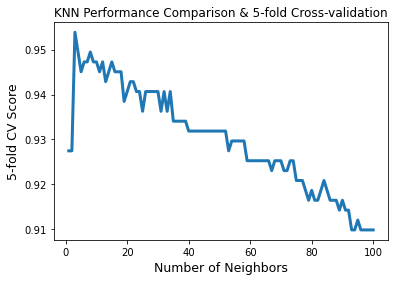

In [59]:
## Nils Plot cross-validation scores for different number of neighbours using GridSearchCV after feature selection ##


N_neighbors = np.arange(1, 101, 1)
param_grid = {'n_neighbors': N_neighbors} 

cv = 5
max_cv_score, K_opt, mean_cv_scores, test_score = KNN_GridSearch(param_grid, cv, X_train, X_test, y_train, y_test)

print('The best number of neighbors for KNN based on {}-fold cross-validation and without feature seletion/extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)   
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

# Part 4: Feature Extraction

In this part of the project, principal component analysis (PCA) is used for feature extraction instead of feature selection. PCA uses singular value decomposition (SVD) of the (training) data or (equivalently eigen decomposition of the covariance matrix) to extract some new features which represent major cumulative variance of the data well. 

For more information regarding PCA you may use the following resources:

1- https://www.youtube.com/watch?v=FgakZw6K1QQ&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=24

2- https://www.youtube.com/watch?v=HMOI_lkzW08&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=25

3- https://www.youtube.com/watch?v=oRvgq966yZg&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=26

4- https://www.youtube.com/watch?v=Lsue2gEM9D0&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=28&t=191s

Here, we need to split and standardize the original data again, as the previous data (`X_train` and `X_test`) was updated after feature selection.

In [67]:
## Split and standardize the orginal data for feature extraction ##

X_train, X_test, y_train, y_test = split_standard(df, 'target', test_size=0.2, random_state=0)  # 80% training and 20% test

**Question 23:** For PCA analysis consider n_components=0.95 which automatically considers enough number of features to reach 95% of the cumulative variance of the training data. Train a PCA model using the training set, then project the test data to the new extracted features to obtain the new test set. Find the number of prinicpal components (extracted features) in this case. 

In [46]:
## Apply principal component analysis for feature extraction ##

pca = PCA(n_components=0.95)  # The number of components for PCA chosen so that the cumulative explained variance is larger than this amount which is between zero and one
X_train = pca.fit_transform(X_train)  # PCA applied to the training data
X_test = pca.transform(X_test)  # Test data is projected to the principal components 

In [47]:
N_features = pca.n_components_  # Number of PCA components or extracted features
N_features

10

In [68]:
#Nils
## Apply principal component analysis for feature extraction ##

pca = PCA(n_components=0.95) # The number of components for PCA chosen so that the cumulative explained variance is larger than this amount which is between zero and one

pca.fit(X_train)# PCA applied to the training data

pca.transform(X_test) # Test data is projected to the principal components 

array([[ 2.31956167,  2.01663237, -2.27975304, ...,  0.97554265,
         0.47587714, -0.03228061],
       [-2.74497982, -1.69023498, -0.23729531, ...,  0.12618479,
         0.45891455, -0.28083062],
       [-3.15651784, -2.29934377, -0.14274523, ...,  0.21628062,
        -0.03504644, -0.55829097],
       ...,
       [ 4.65286147, -0.65568721, -0.45446847, ..., -1.10951599,
        -0.41920796,  0.66370694],
       [ 2.77621544, -1.87176342, -0.90709741, ...,  0.01510452,
        -0.1188745 , -0.08940572],
       [-0.52458925, -0.84827669, -0.66890972, ...,  1.08821773,
        -0.95186601, -0.47824583]])

In [69]:
#Nils
len(pca.transform(X_test)[0]) # Number of PCA components or extracted features

10

**Question 24:** Similar to part 2 and 3, here after feature extraction in 3 sections KNN is used for predicting breast cancer. The first section is without cross-validation, the second section includes cross-validation using `cross_val_score` in a loop, and the last section of part 3 presents the results of performing cross-validation using `GridSearchCV` without using a loop. Use the functions created in part 2 to get these tasks done. Is it seen that for the same number of features, feature extraction using PCA results in better accuracy scores compared to feature selection based on correlation?

## Part 4.1: KNN without cross-validation after feature extraction

The best test score for KNN without cross-validation after feature extraction is 0.9736842105263158 which is for K=16 number of neighbors. 




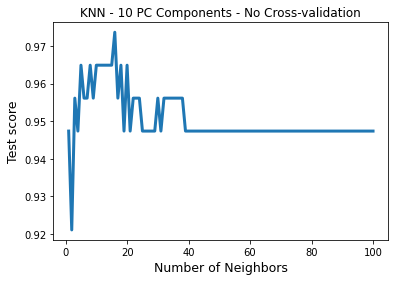

In [48]:
## Plot test scores for different number of neighbours after feature extraction without cross-validation ##

N_neighbors = np.arange(1, 101, 1)  # Array of neighbors
max_test_score, K_opt, test_scores = KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test)

print('The best test score for KNN without cross-validation after feature extraction is {} which is for K={} number of neighbors. \n\n'.format(max_test_score, K_opt))

plt.plot(N_neighbors, test_scores, linewidth = 3) 
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('Test score', fontsize=12.5)  
plt.title('KNN - {} PC Components - No Cross-validation'.format(N_features), fontsize=12)  
plt.show()

The best test score for KNN without cross-validation and with PCS feature extraction is 0.9736842105263158 for K=15 number of neighbors, which is better then the result using feature selection. 




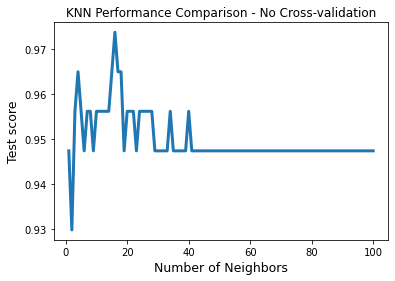

In [70]:
#Nils
## Plot test scores for different number of neighbours after feature extraction without cross-validation ##

X_train_pca = pca.transform(X_train)

X_test_pca = pca.transform(X_test)

N_neighbors = np.arange(1, 101, 1)  # Array of neighbors

max_test_score, K_opt, test_scores = KNN_without_CV(N_neighbors, X_train, X_test, y_train, y_test)

best_test_score_feature_selection = 0.9473684210526315  

if max_test_score > best_test_score_feature_selection:
    print('The best test score for KNN without cross-validation and with PCS feature extraction is {} for K={} number of neighbors, which is better then the result using feature selection. \n\n'.format(max_test_score, K_opt))
else:
    print('The best test score for KNN without cross-validation and with PCS feature extraction is {} for K={} number of neighbors, which is NOT better then the result using feature selection. \n\n'.format(max_test_score, K_opt))
    
plt.plot(N_neighbors, test_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5) 
plt.ylabel('Test score', fontsize=12.5) 
plt.title('KNN Performance Comparison - No Cross-validation', fontsize=12) 
plt.show()

## Part 4.2: KNN with cross-validation after feature extraction

The best number of neighbors for KNN based on 5-fold cross-validation after feature extraction is K=16 for which cross-validation score is 0.964835164835165 and the test score is 0.9736842105263158. 




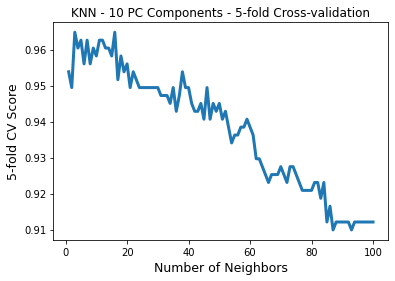

In [49]:
## Plot cross-validation scores for different number of neighbours after feature extraction ##

max_cv_score, K_opt, mean_cv_scores, test_score = KNN_with_CV(N_neighbors, cv, X_train, X_test, y_train, y_test)  # Finding the best number of neighbors based on the best cross-validation score

print('The best number of neighbors for KNN based on {}-fold cross-validation after feature extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN - {} PC Components - {}-fold Cross-validation'.format(N_features, cv), fontsize=12) 
plt.show() 

The best test score for KNN without cross-validation and with PCS feature extraction is 0.9736842105263158 for K=15 number of neighbors, which is better then the result using feature selection. 




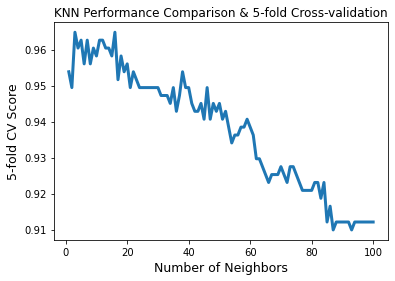

In [71]:
#Nils

cv = 5  # Number of folds in cross-validation
max_cv_score, K_opt, mean_cv_scores, test_score = KNN_with_CV(N_neighbors, cv, X_train_pca, X_test_pca, y_train, y_test)  # Finding the best number of neighbors based on the best cross-validation score

best_test_score_feature_selection = 0.9298245614035088

if max_test_score > best_test_score_feature_selection:
    print('The best test score for KNN without cross-validation and with PCS feature extraction is {} for K={} number of neighbors, which is better then the result using feature selection. \n\n'.format(max_test_score, K_opt))
else:
    print('The best test score for KNN without cross-validation and with PCS feature extraction is {} for K={} number of neighbors, which is NOT better then the result using feature selection. \n\n'.format(max_test_score, K_opt))
    
plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

## Part 4.3: KNN with cross-validation using GridSearchCV after feature extraction

The best number of neighbors for KNN based on 5-fold cross-validation after feature extraction is K=16 for which cross-validation score is 0.964835164835165 and the test score is 0.9736842105263158. 




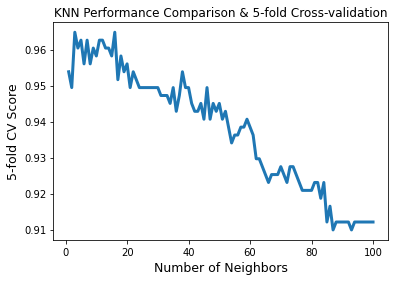

In [50]:
## Plot cross-validation scores for different number of neighbours using GridSearchCV after feature extraction ##

max_cv_score, K_opt, mean_cv_scores, test_score = KNN_GridSearch(N_neighbors, cv, X_train, X_test, y_train, y_test)

print('The best number of neighbors for KNN based on {}-fold cross-validation after feature extraction is K={} for which cross-validation score is {} and the test score is {}. \n\n'.format(cv, K_opt, max_cv_score, test_score))

plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)  
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)   
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)   
plt.show() 

The best test score for KNN without cross-validation and with PCS feature extraction is 0.9736842105263158 for K=15 number of neighbors, which is better then the result using feature selection. 




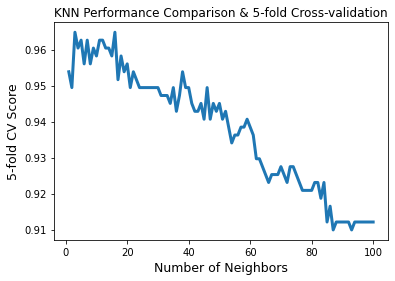

In [72]:
#Nils
## Plot cross-validation scores for different number of neighbours using GridSearchCV after feature extraction ##
max_cv_score, K_opt, mean_cv_scores, test_score = KNN_GridSearch(N_neighbors, cv, X_train_pca, X_test_pca, y_train, y_test)

best_test_score_feature_selection = 0.9298245614035088

if max_test_score > best_test_score_feature_selection:
    print('The best test score for KNN without cross-validation and with PCS feature extraction is {} for K={} number of neighbors, which is better then the result using feature selection. \n\n'.format(max_test_score, K_opt))
else:
    print('The best test score for KNN without cross-validation and with PCS feature extraction is {} for K={} number of neighbors, which is NOT better then the result using feature selection. \n\n'.format(max_test_score, K_opt))
    
plt.plot(N_neighbors, mean_cv_scores, linewidth = 3)  
plt.xlabel('Number of Neighbors', fontsize=12.5)   
plt.ylabel('{}-fold CV Score'.format(cv), fontsize=12.5)  
plt.title('KNN Performance Comparison & {}-fold Cross-validation'.format(cv), fontsize=12)  
plt.show() 

# Part 5: Standardization, Feature Extraction, Cross-Validation and Parameter Tuning, All Together Using Pipeline and GridSearchCV (NO DATA LEAKAGE) 

One of the basic characteristics of a properly implemented machine learning algorithm is avoiding data leakage. There should be no leakage from the test data, and the test data is for the final evaluation of our model. In fact if we are doing cross-validation, there should be no leakage from the validation set (test set inide the training data used for hyperparameter tuning in cross-validation) either. Avoiding leakage from the validation set and the test set at the same time can be a difficult task. That is when the incredible power of `Pipeline` in `scikit-learn` comes into play. As a matter of fact, a common mistake made by a lot of beginner data scientists is not using `Pipeline`. As a `scikit-learn` developer said: if you are not using `Pipeline` you are probably doing it wrong. 

The correct manner of doing standardization and feature selection/extraction is including and performing them in cross-validation making sure there is no leakage from the validation and test sets. That is why in part 5 of this project we use `Pipeline` to do standardization, PCA and KNN in cross-validation performed by `GridSearchCV`. 

Here, grid search is done over a range of PCA components (from 1 to 30) and a range of KNN neighbors (from 1 to 100) at the same time. This means `GridSearchCV` perfoms cross-validation for 3000 cases to find the best cross-validation score. Then for the optimum combination of PCA components and number of neighbors the test score is reported. Finally a contour plot is used to visualize how cross-validation score changes over ranges of PCA components and KNN neighbors. 

**Question 25:** Perform the tasks mentioned for part 5. 

Useful resources for this section:

1- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

2- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

3- https://scikit-learn.org/stable/modules/compose.html

In [95]:
## Performing standardization, feature extraction, cross-validation and parameter tuning all together 
#using Pipeline and GridSearchCV (NO DATA LEAKAGE) ##

def pipeline(data, target):


    pipe = Pipeline([('standard_scale', StandardScaler()),
                 ('pca', PCA()),
                 ('knn', KNeighborsClassifier())])
    
    knn_params = list(range(1, 100))
    
    pca_params = list(range(1, 20)) + [0.5, 0.75, 0.95]
 
    param_grid = {'knn__n_neighbors': knn_params, 'pca__n_components':  pca_params }


    GridSearch = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


    GridSearch.fit(data, target)
    
    mean_cv_scores = GridSearch.cv_results_['mean_test_score']  # Average of cross-validation scores
    max_cv_score = GridSearch.best_score_  # The best cross-validation score
    K_opt = GridSearch.best_params_['knn__n_neighbors']  # Number of neighbors for the best cross-validation score
    N_opt = GridSearch.best_params_['pca__n_components']
    test_score = GridSearch.score(X_test, y_test)  # Finding the test score based on the best number of neighbors found using cross-validation

    return max_cv_score, K_opt, N_opt, mean_cv_scores, test_score


In [101]:
GridSearch.best_params_

{'knn__n_neighbors': 5, 'pca__n_components': 11}

In [102]:
GridSearch.best_score_

0.9714285714285715

In [96]:
pipeline(X_train, y_train)

(0.9714285714285715,
 5,
 11,
 array([0.85494505, 0.90989011, 0.93186813, ..., 0.91208791, 0.91208791,
        0.90989011]),
 0.956140350877193)

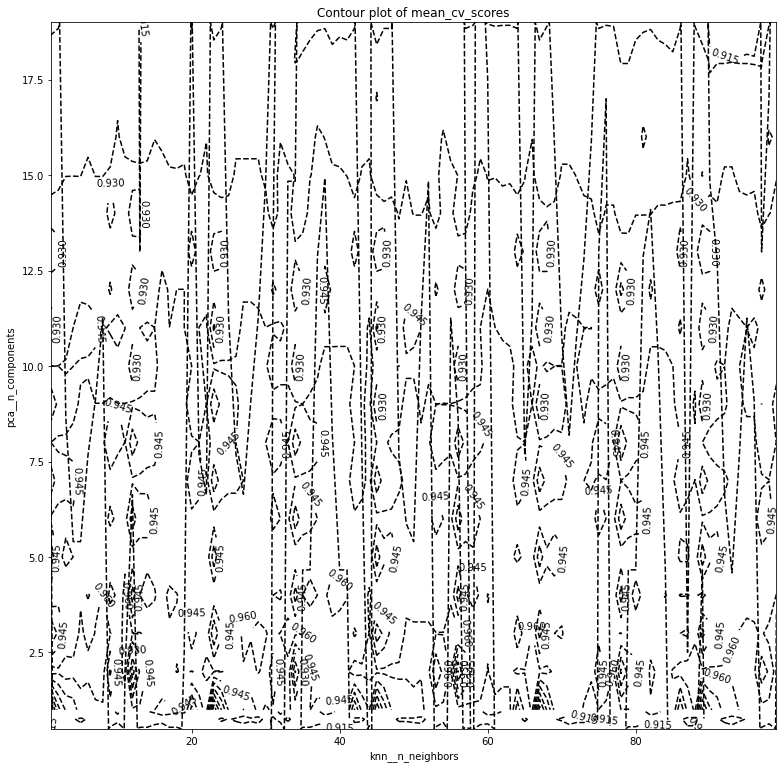

In [99]:
## Contour plot for cross-validation score for a range of input features used in cross-validation ##

X, Y = np.meshgrid(GridSearch.param_grid['knn__n_neighbors'], GridSearch.param_grid['pca__n_components'])

Z = GridSearch.cv_results_['mean_test_score'].reshape(len(pca_params), len(knn_params))



plt.figure(figsize = (13,13))
cp = plt.contour(X, Y, Z, colors='black', linestyles='dashed')
plt.clabel(cp, inline=True, 
          fontsize=10)
plt.title('Contour plot of mean_cv_scores')
plt.xlabel('knn__n_neighbors')
plt.ylabel('pca__n_components')
plt.show()

**Question 26:** Summarize your findings in this project.

In [ ]:
# In this project KNN for binary classification was applied to the Breast cancer wisconsin (diagnostic) dataset
# using sklearn to classify samples in the dataset as either malignant or benign. 

# Different pre-processing methods were evaluated: 
# (i) feature selection based on correlations between pre-determined features in the dataset and the target variable. 
# (ii) principal component analysis, projecting the training dataset onto n coordinate axis/extracted features which 
# maximises variance across samples.

# Then cross validation was performed to optimise hyperparameters of the model, in particular to find the optimal 
# number of neighbors used in KNN, and the optimal number of features-dimensions of the transformed dataset under PCA. 
# For this end, sklearn.cross_val_score and GridSearchCV was evaluated respectively. To avoid any data-leakage in 
# the cross-validation step, sklearn.Pipeline was utilised.

# It was found that the best results of the KNN model on the test data set was obtained for hyperparameter values 
# set to 5 number of neighbors and 11 PCA dimensions, as determined using sklearn.Pipeline and GridSearchCV. 
# With these settings the KNN model classified the samples in the test set with an accuracy score of 0.9714286.